In [1]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
data = sm.datasets.co2.load_pandas()
y = data.data

In [3]:
# The 'MS' string groups the data in buckets by start of the month
y = y['co2'].resample('MS').mean()

# The term bfill means that we use the value before filling in missing values
y = y.fillna(y.bfill())

print(y)

1958-03-01    316.100000
1958-04-01    317.200000
1958-05-01    317.433333
1958-06-01    315.625000
1958-07-01    315.625000
                 ...    
2001-08-01    369.425000
2001-09-01    367.880000
2001-10-01    368.050000
2001-11-01    369.375000
2001-12-01    371.020000
Freq: MS, Name: co2, Length: 526, dtype: float64


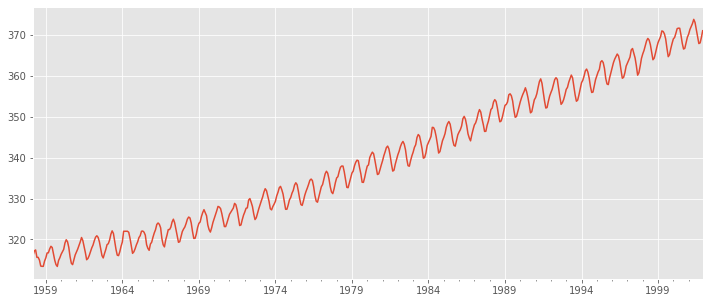

In [4]:
y.plot(figsize=(12, 5))
plt.show()

In [5]:
p = d = q = range(0, 2)

pdq = list(itertools.product(p, d, q))

seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [7]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{} seasonal period :12 months - BIC:{}'.format(param, param_seasonal, results.bic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12) seasonal period :12 months - BIC:7616.846828143603
ARIMA(0, 0, 0)x(0, 0, 1, 12) seasonal period :12 months - BIC:6795.824175723324
ARIMA(0, 0, 0)x(0, 1, 0, 12) seasonal period :12 months - BIC:1859.0685099864318
ARIMA(0, 0, 0)x(0, 1, 1, 12) seasonal period :12 months - BIC:1605.1443849662624
ARIMA(0, 0, 0)x(1, 0, 0, 12) seasonal period :12 months - BIC:1067.423338662914
ARIMA(0, 0, 0)x(1, 0, 1, 12) seasonal period :12 months - BIC:1069.008685512346
ARIMA(0, 0, 0)x(1, 1, 0, 12) seasonal period :12 months - BIC:1370.0950980463683
ARIMA(0, 0, 0)x(1, 1, 1, 12) seasonal period :12 months - BIC:1057.414609610816
ARIMA(0, 0, 1)x(0, 0, 0, 12) seasonal period :12 months - BIC:6889.571737597996
ARIMA(0, 0, 1)x(0, 0, 1, 12) seasonal period :12 months - BIC:6085.377301697266
ARIMA(0, 0, 1)x(0, 1, 0, 12) seasonal period :12 months - BIC:1387.6707559515285
ARIMA(0, 0, 1)x(0, 1, 1, 12) seasonal period :12 months - BIC:1254.0612959794178
ARIMA(0, 0, 1)x(1, 0, 0, 12) season

In [8]:
final_model = sm.tsa.statespace.SARIMAX(y,
                                order=(0, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = final_model.fit()

print(results.summary().tables[1])


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3371      0.039     -8.623      0.000      -0.414      -0.260
ar.S.L12      -0.0010      0.001     -1.739      0.082      -0.002       0.000
ma.S.L12      -0.8746      0.027    -32.793      0.000      -0.927      -0.822
sigma2         0.0983      0.004     22.976      0.000       0.090       0.107


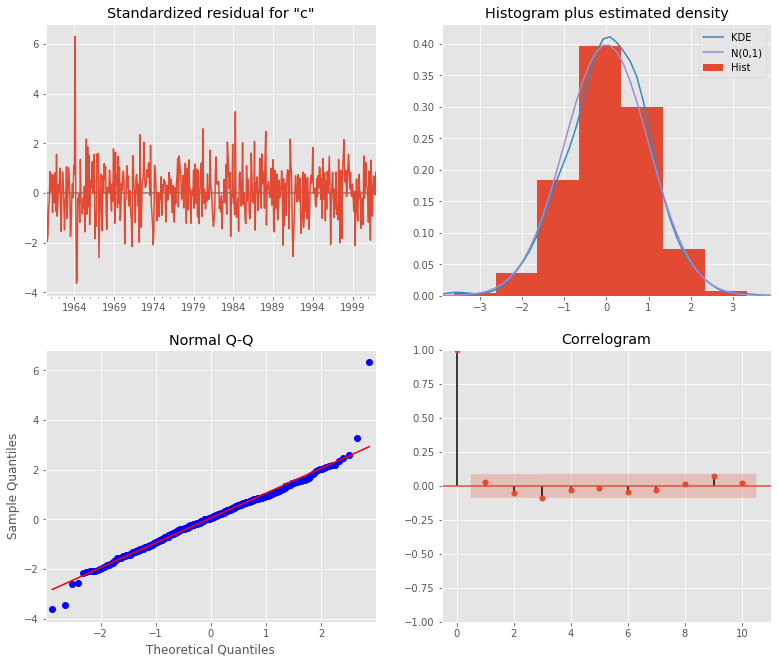

In [9]:
results.plot_diagnostics(figsize=(13, 11))
plt.show()

In [10]:
pred = results.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=False)
pred_conf_int = pred.conf_int()

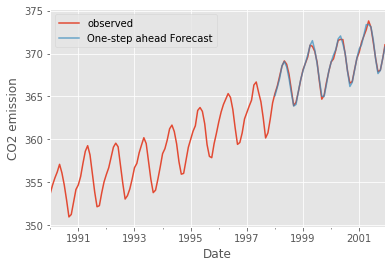

In [11]:
ax = y['1990':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_conf_int.index,
                pred_conf_int.iloc[:, 0],
                pred_conf_int.iloc[:, 1], color='k', alpha=.0)

ax.set_xlabel('Date')
ax.set_ylabel('CO2 emission')
plt.legend()

plt.show()

In [12]:
y_forecasted = pred.predicted_mean
y_truth = y['1998-01-01':]

# estimate mse
mse = ((y_forecasted - y_truth) ** 2).mean()
print('mse : {}'.format(round(mse, 2)))

mse : 0.07


In [13]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=True, full_results=True)
pred_dynamic_conf_int = pred_dynamic.conf_int()

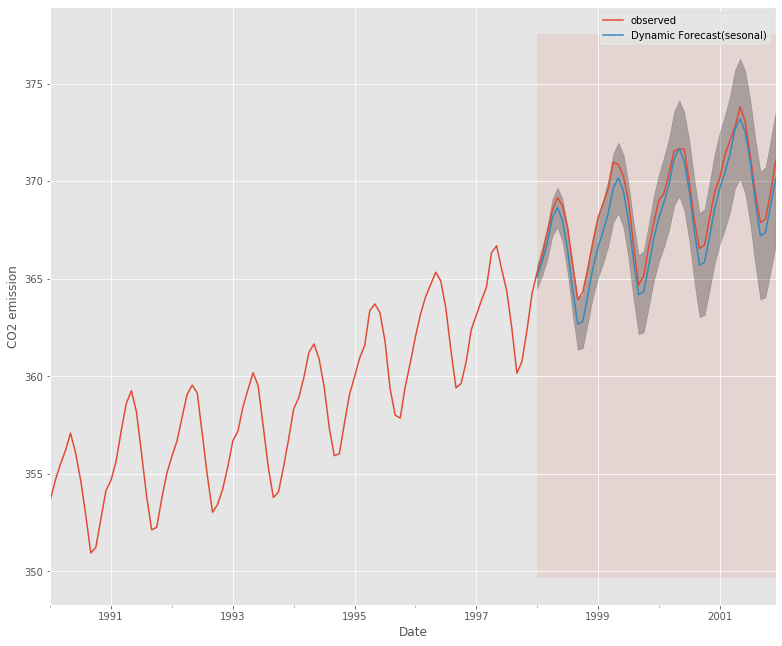

In [14]:
ax = y['1990':].plot(label='observed', figsize=(13, 11))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast(sesonal)', ax=ax)

ax.fill_between(pred_dynamic_conf_int.index,
                pred_dynamic_conf_int.iloc[:, 0],
                pred_dynamic_conf_int.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('1998-01-01'), y.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('CO2 emission')

plt.legend()
plt.show()

In [17]:
y_forecasted = pred_dynamic.predicted_mean
y_truth = y['1998-01-01':]

mse = ((y_forecasted - y_truth) ** 2).mean()
print('mse: {}'.format(round(mse, 2)))

mse: 0.74


In [18]:
# prediction
pred_uc = results.get_forecast(steps=100)

# its conf_int
pred_conf_int = pred_uc.conf_int()

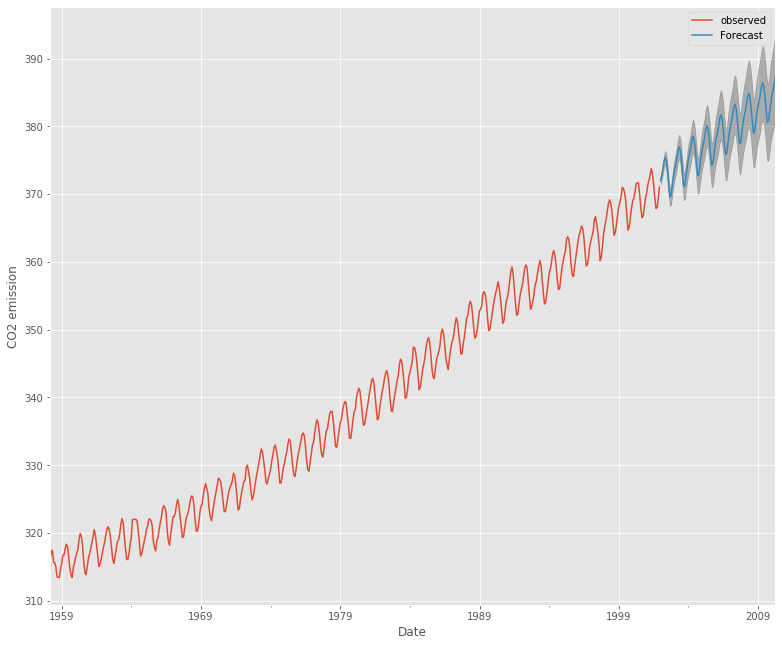

In [22]:
ax = y.plot(label='observed', figsize=(13, 11))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf_int.index,
                pred_conf_int.iloc[:, 0],
                pred_conf_int.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('CO2 emission')

plt.legend()
plt.show()